## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-01 20:09:27--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.76MB/s    in 1.5s    

2025-03-01 20:09:29 (3.76 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [ ]:
import pandas as pd
import numpy as np
from typing import Union

In [ ]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [ ]:
df.shape

(1000209, 4)

In [ ]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()
df.shape

(994852, 4)

In [ ]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [ ]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [ ]:
df_test.head()

,user_id,item_id,rating,datetime
100406,670,1248,4,2000-12-01 00:02:42
100407,670,1249,4,2000-12-01 00:03:23
100408,670,3932,3,2000-12-01 00:03:23
100410,670,1250,4,2000-12-01 00:02:42
100413,670,1259,4,2000-12-01 00:03:23


<Axes: >

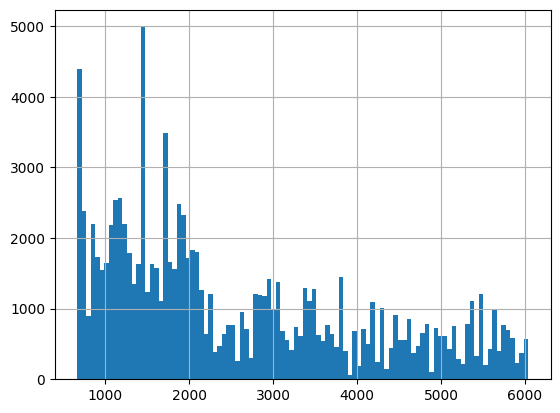

In [ ]:
df_test.user_id.hist(bins=100)

In [ ]:
df_test[df_test.user_id < 1000].shape

(13307, 4)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106471 entries, 100406 to 1000172
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   106471 non-null  int64         
 1   item_id   106471 non-null  int64         
 2   rating    106471 non-null  int64         
 3   datetime  106471 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.1 MB


In [ ]:
df_test.user_id.value_counts()

,count
user_id,
1088,1048
1448,1015
1447,981
678,930
4169,757
...,...
4674,1
1336,1
1048,1


In [ ]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [ ]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

In [ ]:
df_test[df_test.user_id < 1000].shape

(39611, 4)

<Axes: >

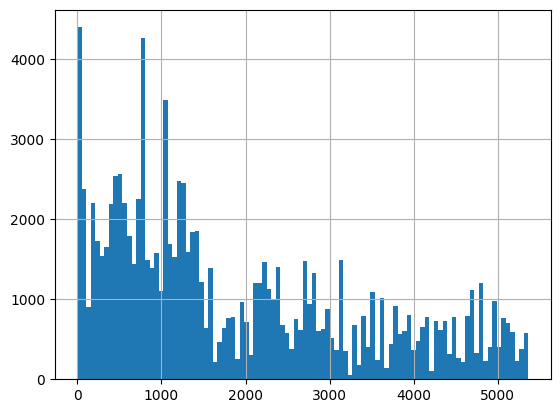

In [ ]:
df_test.user_id.hist(bins=100)

In [ ]:
df_train.head()

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50


In [ ]:
df_train.shape, df_test.shape

((787420, 4), (106471, 4))

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [ ]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    result = np.zeros((n_users, n_items))
    for _, row in df.iterrows():
        result[int(row['user_id']), int(row['item_id'])] = row['rating']
    return result #shape ~ [n_users, n_items]

In [ ]:
interactions = df_to_matrix(df_train)

In [ ]:
interactions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [ ]:
interactions.shape

(5365, 3010)

In [ ]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    rows = df['user_id'].values.astype(int)
    cols = df['item_id'].values.astype(int)
    data = df['rating'].values
    result = coo_array((data, (rows, cols)), shape=(n_users, n_items))
    return result # coo_array

In [ ]:
coo_interactions = df_to_coo(df_train)

In [ ]:
coo_interactions

<5365x3010 sparse array of type '<class 'numpy.int64'>'
	with 787420 stored elements in COOrdinate format>

In [ ]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [ ]:
from scipy.sparse.linalg import svds

In [ ]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)

    if isinstance(interractions, np.ndarray):
        U, S, V = np.linalg.svd(interractions, full_matrices=False)

        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]

    else:
        interractions = interractions.astype(float)
        if n_singular_values == -1:
            n_singular_values = min(interractions.shape) - 1

        U, S, V = svds(interractions, k=n_singular_values)
        U = U[:, ::-1]
        S = S[::-1]
        V = V[::-1, :]

    S = np.diag(S)

    return U, S, V

In [ ]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [ ]:
U.shape, S.shape, V.shape

((5365, 3010), (3010, 3010), (3010, 3010))

In [ ]:
interactions.shape

(5365, 3010)

In [ ]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [ ]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    if isinstance(interractions, np.ndarray):
        dense = interractions.copy()
    else:
        dense = interractions.toarray()
    U, S, V = make_svd(interractions, n_singular_values)
    pred = U @ S @ V
    pred[dense != 0] = -float("inf")
    recommendations = pred.argsort(axis=1)[:, ::-1][:, :top_k]

    return recommendations #shape ~ [n_users, top_k]

In [ ]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [ ]:
import time
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in gt_items else 0 for x in predicted])
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])
    if ideal_dcg == 0.0:
        return 0.0
    return rank_dcg / ideal_dcg

def dcg(scores):
    return np.sum((2 ** scores - 1) / np.log2(np.arange(scores.shape[0]) + 2), dtype=np.float64)

def compute_ndcg(recs: np.ndarray, test_interactions: coo_array, top_k: int) -> float:
    test_csr = test_interactions.tocsr()
    n_users = recs.shape[0]
    total_ndcg = 0.0
    user_count = 0

    for u in range(n_users):
        row_arr = test_csr[u:u+1, :].toarray().ravel()
        gt_items = set(np.where(row_arr > 0)[0])
        if not gt_items:
            continue
        predicted = recs[u][:top_k]
        ndcg_val = ndcg_metric(gt_items, predicted)
        total_ndcg += ndcg_val
        user_count += 1

    return total_ndcg / user_count if user_count > 0 else 0.0

def plot_graphs(interactions: Union[np.ndarray, coo_array], test_interactions: coo_array, top_k: int = 100):
    nsv_list = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    times = []

    for n_singular_values in nsv_list:
        start_time = time.time()
        recs = make_svd_recommendations(interactions, n_singular_values=n_singular_values, top_k=top_k)
        elapsed = time.time() - start_time
        times.append(elapsed)
        ndcg_val = compute_ndcg(recs, test_interactions, top_k)
        ndcg_scores.append(ndcg_val)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(nsv_list, ndcg_scores, marker='o')
    plt.xlabel('n_singular_values')
    plt.ylabel('NDCG')
    plt.title('NDCG vs n_singular_values')

    plt.subplot(1, 2, 2)
    plt.plot(nsv_list, times, marker='o')
    plt.xlabel('n_singular_values')
    plt.ylabel('Time (s)')
    plt.title('Time vs n_singular_values (sparse matrix)')

    plt.tight_layout()
    plt.show()

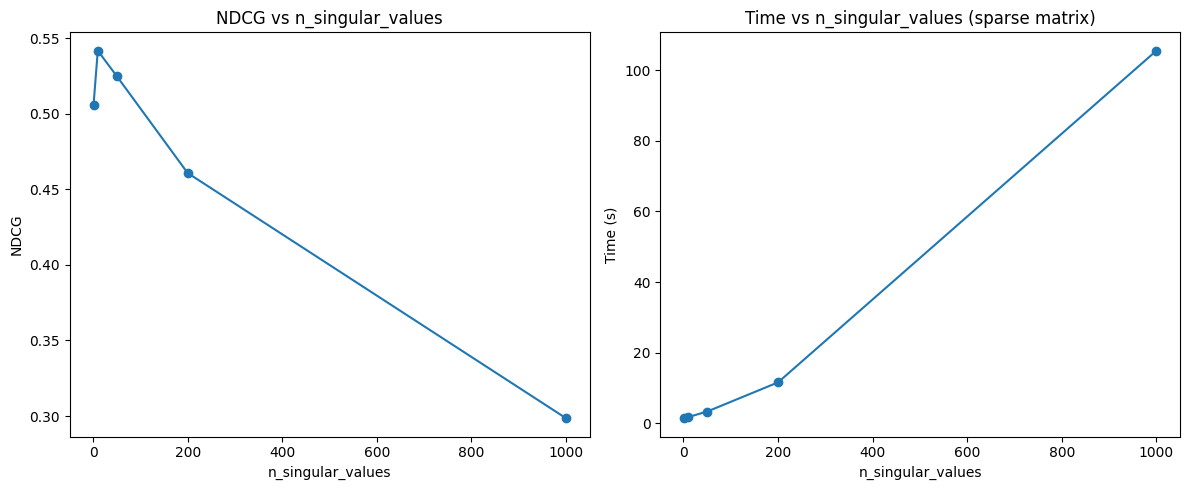

In [ ]:
test_coo_interactions = df_to_coo(df_test)
plot_graphs(coo_interactions, test_coo_interactions, top_k=100)

Время вычисления от n_singular_values растет линейно и монотонно, а вот NDCG метрика максимальна при значении n_singular_values равным 10, что может значить, что именно в них заложена основная информация о предпочтениях пользователей, а добавление дополнительных значений вносит больше шума, чем полезной информации.

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [ ]:
pip install implicit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 36.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from typing import Union
from scipy.sparse import coo_array, coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01
):
    if isinstance(interactions, np.ndarray):
        interactions = coo_matrix(interactions)

    train_matrix = (interactions * alpha).astype(np.float32).tocsr()

    als_model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=15
    )
    als_model.fit(train_matrix)

    num_users = train_matrix.shape[0]
    user_indices = np.arange(num_users)
    recommendations = np.zeros((num_users, top_k), dtype=np.int32)

    for idx, user in enumerate(user_indices):
        rec_items, _ = als_model.recommend(user, train_matrix.getrow(user), N=top_k, filter_already_liked_items=True)
        recommendations[idx, :len(rec_items)] = rec_items

    return recommendations #shape ~ [n_users, top_k]

In [ ]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    n_factors = trial.suggest_categorical("n_factors", [10, 50, 100, 200, 300])
    alpha = trial.suggest_categorical("alpha", [1.0, 10.0, 20.0, 50.0])
    regularization = trial.suggest_categorical("regularization", [0.001, 0.01, 0.1, 1.0])

    recs = make_als_recommendations(
        interactions,
        top_k=100,
        n_factors=n_factors,
        alpha=alpha,
        regularization=regularization
    )

    return compute_ndcg(recs, test_coo_interactions, top_k=100)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Лучшие параметры:", study.best_params)
print("Максимальное NDCG:", study.best_value)

[I 2025-03-01 21:55:41,139] A new study created in memory with name: no-name-bcf18d45-3d48-4f88-8ecb-0ef88ded3352


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:56:18,669] Trial 0 finished with value: 0.44946273072855913 and parameters: {'n_factors': 200, 'alpha': 20.0, 'regularization': 0.001}. Best is trial 0 with value: 0.44946273072855913.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:56:29,390] Trial 1 finished with value: 0.44953441202108313 and parameters: {'n_factors': 100, 'alpha': 20.0, 'regularization': 1.0}. Best is trial 1 with value: 0.44953441202108313.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:57:20,147] Trial 2 finished with value: 0.4359824298618368 and parameters: {'n_factors': 300, 'alpha': 20.0, 'regularization': 0.001}. Best is trial 1 with value: 0.44953441202108313.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:57:31,382] Trial 3 finished with value: 0.46037684663147815 and parameters: {'n_factors': 100, 'alpha': 10.0, 'regularization': 0.01}. Best is trial 3 with value: 0.46037684663147815.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:57:37,783] Trial 4 finished with value: 0.5348627465343813 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:57:48,608] Trial 5 finished with value: 0.448213450729477 and parameters: {'n_factors': 100, 'alpha': 20.0, 'regularization': 0.001}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:58:25,573] Trial 6 finished with value: 0.44004444204619225 and parameters: {'n_factors': 200, 'alpha': 50.0, 'regularization': 0.001}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:59:16,089] Trial 7 finished with value: 0.44716414327471043 and parameters: {'n_factors': 300, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:59:28,276] Trial 8 finished with value: 0.46698819127672253 and parameters: {'n_factors': 50, 'alpha': 10.0, 'regularization': 0.01}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:59:40,517] Trial 9 finished with value: 0.4182563902626666 and parameters: {'n_factors': 50, 'alpha': 50.0, 'regularization': 1.0}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:59:47,024] Trial 10 finished with value: 0.5348627465343813 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 21:59:54,409] Trial 11 finished with value: 0.5348627465343813 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:00:00,791] Trial 12 finished with value: 0.5348627465343813 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:00:08,337] Trial 13 finished with value: 0.5348627465343813 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 4 with value: 0.5348627465343813.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:00:15,078] Trial 14 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:00:22,282] Trial 15 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:00:30,274] Trial 16 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:00:36,689] Trial 17 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:00:44,605] Trial 18 finished with value: 0.4287085668374529 and parameters: {'n_factors': 10, 'alpha': 50.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:01:20,973] Trial 19 finished with value: 0.463055150085568 and parameters: {'n_factors': 200, 'alpha': 10.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:01:32,292] Trial 20 finished with value: 0.5163054790468523 and parameters: {'n_factors': 50, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:01:39,042] Trial 21 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:01:47,026] Trial 22 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:01:53,543] Trial 23 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:02:01,040] Trial 24 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:02:50,032] Trial 25 finished with value: 0.44716414327471043 and parameters: {'n_factors': 300, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 14 with value: 0.5357959765522812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:02:56,438] Trial 26 finished with value: 0.5373086513422105 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:03:04,200] Trial 27 finished with value: 0.5030338211500497 and parameters: {'n_factors': 10, 'alpha': 10.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:03:10,742] Trial 28 finished with value: 0.4270306669582772 and parameters: {'n_factors': 10, 'alpha': 50.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:03:47,927] Trial 29 finished with value: 0.44988746967246396 and parameters: {'n_factors': 200, 'alpha': 20.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:03:58,635] Trial 30 finished with value: 0.5000310063708092 and parameters: {'n_factors': 100, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:04:06,327] Trial 31 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:04:12,834] Trial 32 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:04:20,486] Trial 33 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:04:26,947] Trial 34 finished with value: 0.4783421211884185 and parameters: {'n_factors': 10, 'alpha': 20.0, 'regularization': 0.001}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:05:20,061] Trial 35 finished with value: 0.44807004237300035 and parameters: {'n_factors': 300, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:05:30,931] Trial 36 finished with value: 0.5016463914790849 and parameters: {'n_factors': 100, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:06:08,259] Trial 37 finished with value: 0.44946273072855913 and parameters: {'n_factors': 200, 'alpha': 20.0, 'regularization': 0.001}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:06:16,437] Trial 38 finished with value: 0.5030338211500497 and parameters: {'n_factors': 10, 'alpha': 10.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:06:28,686] Trial 39 finished with value: 0.5163054790468523 and parameters: {'n_factors': 50, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:07:15,714] Trial 40 finished with value: 0.42954431426687545 and parameters: {'n_factors': 300, 'alpha': 50.0, 'regularization': 0.001}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:07:23,110] Trial 41 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:07:29,863] Trial 42 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:07:36,958] Trial 43 finished with value: 0.5357959765522812 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:07:47,759] Trial 44 finished with value: 0.5016463914790849 and parameters: {'n_factors': 100, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:07:54,191] Trial 45 finished with value: 0.5373086513422105 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:08:01,636] Trial 46 finished with value: 0.5373086513422105 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:08:08,423] Trial 47 finished with value: 0.4786513111432315 and parameters: {'n_factors': 10, 'alpha': 20.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:08:19,979] Trial 48 finished with value: 0.5159147132644442 and parameters: {'n_factors': 50, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-01 22:08:27,451] Trial 49 finished with value: 0.5030338211500497 and parameters: {'n_factors': 10, 'alpha': 10.0, 'regularization': 0.01}. Best is trial 26 with value: 0.5373086513422105.


Лучшие параметры: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.01}
Максимальное NDCG: 0.5373086513422105


svd получилост чуть лучше als по метрике ndcg. Интересно.

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [ ]:
# 1. Бинаризация всех интеракций: все оценки - 1
df_train_bin = df_train.copy()
df_train_bin['rating'] = 1

# 2. Бинаризация только для оценок 4 и 5: >=4 - 1, иначе 0
df_train_45 = df_train.copy()
df_train_45['rating'] = (df_train_45['rating'] >= 4).astype(int)

# 3. Оценки 4 и 5 - 1, ниже 4 - -1
df_train_45_neg = df_train.copy()
df_train_45_neg['rating'] = df_train_45_neg['rating'].apply(lambda r: 1 if r >= 4 else -1)

# 4. Оценки 4 и 5 - 1, ниже 4 - -1 с учетом времени (сглаживание)
df_train_45_neg_time = df_train.copy()
df_train_45_neg_time['rating'] = df_train_45_neg_time['rating'].apply(lambda r: 1 if r >= 4 else -1)
max_date = df_train_45_neg_time['datetime'].max()

df_train_45_neg_time['days_diff'] = (max_date - df_train_45_neg_time['datetime']).dt.days
df_train_45_neg_time['rating'] = df_train_45_neg_time['rating'] * np.exp(-df_train_45_neg_time['days_diff'] / 30)

matrices = {
    "Бинаризация всех интеракций": df_to_coo(df_train_bin),
    "Оценки >=4: 1, иначе 0": df_to_coo(df_train_45),
    "Оценки >=4: 1, иначе -1": df_to_coo(df_train_45_neg),
    "Оценки >=4 с временным сглаживанием": df_to_coo(df_train_45_neg_time)
}

test_coo = df_to_coo(df_test)
results = {}

for variant, matrix in matrices.items():
    print(f"\nОбработка варианта: {variant}")

    dense_matrix = matrix.toarray()
    recs_svd = make_svd_recommendations(dense_matrix, n_singular_values=-1, top_k=100)
    ndcg_svd = compute_ndcg(recs_svd, test_coo, top_k=100)

    recs_als, als_model, train_matrix_used = make_als_recommendations(matrix, top_k=100, n_factors=100, alpha=1.0, regularization=0.01)
    ndcg_als = compute_ndcg(recs_als, test_coo, top_k=100)

    results[variant] = {"NDCG SVD": ndcg_svd, "NDCG ALS": ndcg_als}
    print(f"  SVD NDCG: {ndcg_svd:.4f}")
    print(f"  ALS NDCG: {ndcg_als:.4f}")

print("\nСводные результаты:")
for variant, metrics in results.items():
    print(f"{variant}: SVD NDCG = {metrics['NDCG SVD']:.4f}, ALS NDCG = {metrics['NDCG ALS']:.4f}")


Обработка варианта: Бинаризация всех интеракций


  0%|          | 0/15 [00:00<?, ?it/s]

  SVD NDCG: 0.3781
  ALS NDCG: 0.4979

Обработка варианта: Оценки >=4: 1, иначе 0


  0%|          | 0/15 [00:00<?, ?it/s]

  SVD NDCG: 0.3417
  ALS NDCG: 0.4991

Обработка варианта: Оценки >=4: 1, иначе -1


  0%|          | 0/15 [00:00<?, ?it/s]

  SVD NDCG: 0.3137
  ALS NDCG: 0.5023

Обработка варианта: Оценки >=4 с временным сглаживанием


  0%|          | 0/15 [00:00<?, ?it/s]

  SVD NDCG: 0.3167
  ALS NDCG: 0.5122

Сводные результаты:
Бинаризация всех интеракций: SVD NDCG = 0.3781, ALS NDCG = 0.4979
Оценки >=4: 1, иначе 0: SVD NDCG = 0.3417, ALS NDCG = 0.4991
Оценки >=4: 1, иначе -1: SVD NDCG = 0.3137, ALS NDCG = 0.5023
Оценки >=4 с временным сглаживанием: SVD NDCG = 0.3167, ALS NDCG = 0.5122


Способ 4 сработал лучше всех!

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [ ]:
import numpy as np

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None
        self.train_mask = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        n_users, n_items = interactions.shape
        self.train_mask = interactions > 0
        p = (interactions > 0).astype(np.float64)
        c = 1 + self.alpha * interactions

        np.random.seed(0)
        X = np.random.normal(scale=0.01, size=(n_users, self.n_factors))
        Y = np.random.normal(scale=0.01, size=(n_items, self.n_factors))
        lambda_I = self.reg_coef * np.eye(self.n_factors)

        for it in range(n_iterations):
            YTY = Y.T @ Y
            for u in range(n_users):
                idx = np.where(self.train_mask[u])[0]
                if len(idx) == 0:
                    continue
                Cu_minus_I = c[u, idx] - 1

                A = YTY.copy()
                for i, w in zip(idx, Cu_minus_I):
                    A += w * np.outer(Y[i], Y[i])
                A += lambda_I
                b = np.zeros(self.n_factors)
                for i in idx:
                    b += c[u, i] * Y[i]
                X[u] = np.linalg.solve(A, b)

            XTX = X.T @ X
            for i in range(n_items):
                idx = np.where(self.train_mask[:, i])[0]
                if len(idx) == 0:
                    continue
                Ci_minus_I = c[idx, i] - 1
                A = XTX.copy()
                for u, w in zip(idx, Ci_minus_I):
                    A += w * np.outer(X[u], X[u])
                A += lambda_I
                b = np.zeros(self.n_factors)
                for u in idx:
                    b += c[u, i] * X[u]
                Y[i] = np.linalg.solve(A, b)

            print(f"Iteration {it + 1}/{n_iterations} completed.")

        self.user_factors = X
        self.item_factors = Y

    def predict(self, top_k: int = 100):
        scores = self.user_factors @ self.item_factors.T
        scores[self.train_mask] = -np.inf

        n_users = scores.shape[0]
        predicts = np.zeros((n_users, top_k), dtype=np.int32)
        for u in range(n_users):
            top_indices = np.argpartition(scores[u], -top_k)[-top_k:]
            top_indices = top_indices[np.argsort(scores[u][top_indices])[::-1]]
            predicts[u] = top_indices
        return predicts # shape ~ [n_users, top_k]

In [ ]:
print("Обучение iALS (на NumPy)...")
ials_model = iALS(n_factors=100, alpha=1.0, reg_coef=0.01)
ials_model.fit(interactions, n_iterations=10)
preds_ials = ials_model.predict(top_k=100)
ndcg_ials = compute_ndcg(preds_ials, test_coo, top_k=100)
print(f"iALS (NumPy) NDCG: {ndcg_ials:.4f}")

print("\nОбучение implicit ALS...")
recs_implicit, als_model, train_matrix_used = make_als_recommendations(
    interactions, top_k=100, n_factors=100, alpha=1.0, regularization=0.01
)
ndcg_implicit = compute_ndcg(recs_implicit, test_coo, top_k=100)
print(f"implicit ALS NDCG: {ndcg_implicit:.4f}")

Обучение iALS (на NumPy)...
Iteration 1/10 completed.
Iteration 2/10 completed.
Iteration 3/10 completed.
Iteration 4/10 completed.
Iteration 5/10 completed.
Iteration 6/10 completed.
Iteration 7/10 completed.
Iteration 8/10 completed.
Iteration 9/10 completed.
Iteration 10/10 completed.
iALS (NumPy) NDCG: 0.5020

Обучение implicit ALS...


  0%|          | 0/15 [00:00<?, ?it/s]

implicit ALS NDCG: 0.5000


Метрики сравнимы. Как и говорилось в задании. Хорошо.